LIMPIEZA Y COMBINACION DE LAS BASES DE DATOS (PASO 1)

In [14]:
import pandas as pd

# Cargar archivos CSV
clientes = pd.read_csv('base_clientes_final.csv')
transacciones = pd.read_csv('base_transacciones_final.csv')

# Limpiar nombres de columnas por si acaso
clientes.rename(columns=lambda x: x.strip(), inplace=True)
transacciones.rename(columns=lambda x: x.strip(), inplace=True)

# Combinar las bases usando 'id',,,
base_completa = transacciones.merge(clientes, on='id', how='left')

# Llenar nulos en giro_comercio
base_completa['giro_comercio'].fillna("SIN CLASIFICAR", inplace=True)

# Vista previa
print("Vista previa de la base combinada:")
print(base_completa.head())

# Guardar base combinada
base_completa.to_csv('base_completa.csv', index=False)
print("\n¡Archivo guardado como 'base_completa.csv'!")

/var/folders/22/pgty7krs2sldhc8zl8xgk9pm0000gn/T/ipykernel_64823/719602773.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  base_completa['giro_comercio'].fillna("SIN CLASIFICAR", inplace=True)


Vista previa de la base combinada:
                                         id       fecha comercio  \
0  91477f382c3cf63ab5cd9263b502109243741158  2022-01-02   AMAZON   
1  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05    RAPPI   
2  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05    RAPPI   
3  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05   AMAZON   
4  91477f382c3cf63ab5cd9263b502109243741158  2022-01-05   AMAZON   

                                giro_comercio tipo_venta  monto  \
0  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   5.99   
1   SERVICIOS EMPRESARIALES - NO CLASIFICADOS    digital  13.01   
2   SERVICIOS EMPRESARIALES - NO CLASIFICADOS    digital  15.84   
3  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   8.17   
4  COMERCIOS ELECTRONICOS (VTAS POR INTERNET)    digital   2.54   

  fecha_nacimiento  fecha_alta  id_municipio  id_estado  \
0       1987-09-21  2019-10-28       6519019         65   
1       1987-09-21  2019-10-28     

DETECCIÓN DE GASTOS RECURRENTES (PASO 2)
Hacemos el histograma para determinar un punto de predeccion 

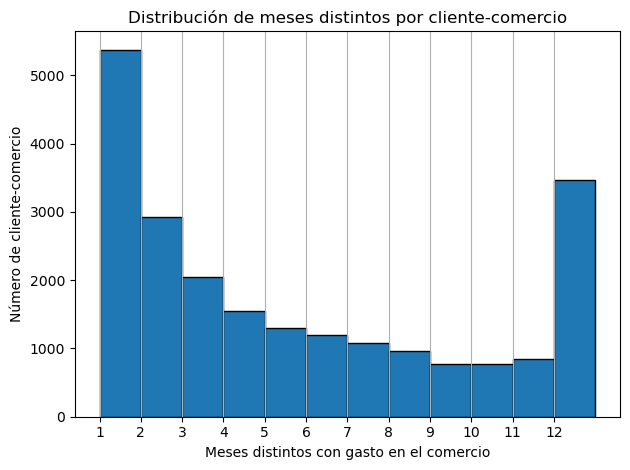

In [16]:
# Asegurarse que la fecha sea tipo datetime 
base_completa['fecha'] = pd.to_datetime(base_completa['fecha'])

# Crear columna año-mes
base_completa['año_mes'] = base_completa['fecha'].dt.to_period('M')

# Agrupar por cliente y comercio para contar meses distintos
frecuencia_mensual = (
    base_completa.groupby(['id', 'comercio'])['año_mes']
    .nunique()
    .reset_index(name='meses_distintos')
)

import matplotlib.pyplot as plt

# Histograma de meses distintos por cliente-comercio
frecuencia_mensual['meses_distintos'].hist(bins=12, edgecolor='black')
plt.xlabel("Meses distintos con gasto en el comercio")
plt.ylabel("Número de cliente-comercio")
plt.title("Distribución de meses distintos por cliente-comercio")
plt.xticks(range(1, 13))  # Meses del 1 al 12
plt.grid(axis='y')
plt.tight_layout()
plt.show()

continuacion parte 2 para las etiquetas

In [17]:
# Calcular estadísticas de monto
# Calcular promedio, std y número de transacciones por cliente-comercio
agrupado_montos = base_completa.groupby(['id', 'comercio'])['monto'].agg(
    monto_prom='mean',
    monto_std='std',
    num_transacciones='count'
).reset_index()

# Eliminar columnas duplicadas antes de hacer el merge para evitar conflictos de sufijos
cols_to_drop = ['monto_prom', 'monto_std', 'num_transacciones']
frecuencia_mensual = frecuencia_mensual.drop(columns=[col for col in cols_to_drop if col in frecuencia_mensual.columns])

# Unir con frecuencia_mensual
frecuencia_mensual = frecuencia_mensual.merge(agrupado_montos, on=['id', 'comercio'], how='left')

# Calcular rupturas de meses consecutivos
def contar_saltes(meses):
    meses_ordenados = sorted(meses.unique())
    diferencias = [meses_ordenados[i+1] - meses_ordenados[i] for i in range(len(meses_ordenados)-1)]
    return sum([d.n != 1 for d in diferencias])  # d.n convierte a valor numérico

rupturas = (
    base_completa.groupby(['id', 'comercio'])['año_mes']
    .apply(contar_saltes)
    .reset_index(name='meses_no_consecutivos')
)

# Unir con frecuencia_mensual
frecuencia_mensual = frecuencia_mensual.merge(rupturas, on=['id', 'comercio'], how='left')

# Crear etiquetas

# General: recurrente si cumple ≥7 meses, estabilidad en monto y pocos saltos
frecuencia_mensual['es_recurrente'] = (
    (frecuencia_mensual['meses_distintos'] >= 7) &
    (frecuencia_mensual['monto_std'] < 100) &
    (frecuencia_mensual['meses_no_consecutivos'] <= 2)
).astype(int)

# Fuerte: exactamente 12 meses de gasto
frecuencia_mensual['es_recurrente_fuerte'] = (
    frecuencia_mensual['meses_distintos'] == 12
).astype(int)

# Vista previa y exportación
print(frecuencia_mensual.sort_values(by='meses_distintos', ascending=False).head())

frecuencia_mensual.to_csv('frecuencia_mensual_etiquetada.csv', index=False)
print("\n¡Archivo guardado como 'frecuencia_mensual_etiquetada.csv'!")


                                             id   comercio  meses_distintos  \
16101  b5dc5a33143864b01fcb864b2c73f4213aac921e  MEGACABLE               13   
11520  8391ff755e5d0f9046039baf33a1bdea75e544ec   SUPERAMA               13   
17964  cd5c72c994e7854aca54f6f66bff0ca8b75e2009    SPOTIFY               13   
17959  cd5c72c994e7854aca54f6f66bff0ca8b75e2009    NETFLIX               13   
17958  cd5c72c994e7854aca54f6f66bff0ca8b75e2009  MICROSOFT               13   

       monto_prom  monto_std  num_transacciones  meses_no_consecutivos  \
16101   37.807692   2.330058                 13                      0   
11520   40.229841  31.233208                126                      0   
17964   23.100000   0.000000                 13                      0   
17959   25.665385   0.956858                 13                      0   
17958   24.852759   8.308693                 29                      0   

       es_recurrente  es_recurrente_fuerte  
16101              1               

PREDECIR COMERCIO Y MONTO SIGUIENTE (PASO 3)

In [18]:
frecuencia_mensual_etiquetada = pd.read_csv('frecuencia_mensual_etiquetada.csv')

base_modelo = base_completa.merge(
    frecuencia_mensual_etiquetada[['id', 'comercio', 'es_recurrente', 'es_recurrente_fuerte']], 
    on=['id', 'comercio'], 
    how='left'
)

# Filtrar solo los clientes recurrentes fuertes
base_no_recurrente = base_modelo[(base_modelo['es_recurrente'] == 1) & (base_modelo['es_recurrente_fuerte'] == 1)].copy()
base_no_recurrente = base_no_recurrente.sort_values(['id', 'fecha']) # Ordenar por cliente y fecha

# Shift por cliente: comercio y monto siguientes
# Calcular targets: comercio y monto siguientes
base_no_recurrente['comercio_siguiente'] = (
    base_no_recurrente.groupby('id')['comercio'].shift(-1)
)
base_no_recurrente['monto_siguiente'] = (
    base_no_recurrente.groupby('id')['monto'].shift(-1)
)

# Eliminar la última compra de cada cliente (no hay siguiente)
base_no_recurrente = base_no_recurrente.dropna(subset=['comercio_siguiente', 'monto_siguiente'])


Modelo clasificación comercio siguiente

In [19]:

from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# One-hot para giro_comercio (o comercio actual)
X = base_no_recurrente[['giro_comercio', 'monto']].copy()
X = pd.get_dummies(X, columns=['giro_comercio'])

y = base_no_recurrente['comercio_siguiente']

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modelo
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

print(f"Accuracy en test: {clf.score(X_test, y_test):.2f}")


Accuracy en test: 0.53


Modelo regresión monto siguiente

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

y_monto = base_no_recurrente['monto_siguiente']

X_train_m, X_test_m, y_train_m, y_test_m = train_test_split(X, y_monto, test_size=0.2, random_state=42)

reg = RandomForestRegressor(n_estimators=100, random_state=42)
reg.fit(X_train_m, y_train_m)

preds = reg.predict(X_test_m)
mse = mean_squared_error(y_test_m, preds)
rmse = np.sqrt(mse)

print(f"RMSE del monto siguiente: {rmse:.2f}")


RMSE del monto siguiente: 43.27


PREDECIR TIEMPO HASTA PRÓXIMA COMPRA (PASO 4)

In [21]:
# Asegurarse de que la fecha esté en formato datetime
base_completa = base_no_recurrente
base_completa['fecha'] = pd.to_datetime(base_completa['fecha'])

# Ordenar por cliente, comercio y fecha (¡fundamental!)
base_completa.sort_values(['id', 'comercio', 'fecha'], inplace=True)

# Crear columnas con la siguiente fecha y monto por cada pareja (id, comercio)
base_completa['fecha_siguiente'] = base_completa.groupby(['id', 'comercio'])['fecha'].shift(-1)
base_completa['monto_siguiente'] = base_completa.groupby(['id', 'comercio'])['monto'].shift(-1)

# Crear variable target: días hasta la siguiente transacción
base_completa['dias_hasta_siguiente'] = (base_completa['fecha_siguiente'] - base_completa['fecha']).dt.days
base_train = base_completa.dropna(subset=['dias_hasta_siguiente'])
base_completa['dias_entre_compras'] = base_completa.groupby(['id', 'comercio'])['fecha'].diff().dt.days

# Estadísticas temporales
estadisticas_tiempo = base_completa.groupby(['id', 'comercio'])['dias_entre_compras'].agg(
    media_dias_entre_compras='mean',
    mediana_dias_entre_compras='median'
).reset_index()

# Agregar estas estadísticas a base_completa
base_completa = base_completa.merge(estadisticas_tiempo, on=['id', 'comercio'], how='left')
#base_completa = base_completa.merge(estadisticas_tiempo2, on=['id', 'comercio'], how='left')

# --- Preparar datos para regresión de días ---

# Filtrar filas que tengan target definido (sin nulos)
base_train = base_completa.dropna(subset=['dias_hasta_siguiente'])

X = base_train[['monto', 'giro_comercio', 'fecha', 'media_dias_entre_compras', 'mediana_dias_entre_compras']].copy()

# Extraer variables de fecha para incluirlas como features
X['mes'] = X['fecha'].dt.month
X['dia_semana'] = X['fecha'].dt.dayofweek

# Eliminar columna fecha porque no la usaremos directamente
X.drop(columns=['fecha'], inplace=True)

# Convertir variable categórica 'giro_comercio' a variables dummy (one-hot encoding)
X = pd.get_dummies(X, drop_first=True)

# Variable objetivo
y = base_train['dias_hasta_siguiente']


Entrenar modelo

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=49)

rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=49)
rf.fit(X_train, y_train)

preds = rf.predict(X_test)
mae = mean_absolute_error(y_test, preds)
medae = median_absolute_error(y_test, preds)
print(f"MAE mejorado: {mae:.2f} días")
print(f"Median Absolute Error: {medae:.2f}")


MAE mejorado: 6.00 días
Median Absolute Error: 3.61


Guardar modelos entrenados

In [23]:
import joblib

# Guardar modelo de clasificación de comercio siguiente
joblib.dump(clf, 'modelo_comercio_siguiente.pkl')

# Guardar modelo de regresión de monto siguiente
joblib.dump(reg, 'modelo_monto_siguiente.pkl')

# Guardar modelo de predicción de días hasta siguiente gasto
joblib.dump(rf, 'modelo_dias_siguiente.pkl')

print("Modelos guardados como archivos .pkl")


Modelos guardados como archivos .pkl
